# Transformer for Language Translation implementation in PyTorch

In this notebook I will go trough an PyTorch implementation of transformer based on [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) paper.

In [another notebook](https://github.com/mf1024/transformers) I implemented Transforer Encoder model and trained it for Language Modeling task. 

In this notebook I will continue and add the Decoder component to the implementation and train the whole on Language Translation task.

Troughout this notebook as well I **use some of the illustrations from the incredible [Illustrated transformer](https://jalammar.github.io/illustrated-transformer) blog post by *Jay Alammar***. I highly recommend you to take a look at it. 


## Dataset

For the translation task I will use a small english-french [dataset](https://raw.githubusercontent.com/mf1024/transformers/master/fra-eng/fra.txt). The dataset consists of just 170k sentences but that is enough to train and demonstrate the Transformer.

I will use the same PyTorch [Dataset](https://github.com/mf1024/transformers/blob/master/fra_eng_dataset.py) implementation to process the sentences and prepare the batches.


## Transformer architecture:

<img src="imgs/transformer.png">

The key idea of Transformer is to avoid using [reccurence](https://arxiv.org/abs/1409.3215) at all for encoding and decoding variable-length sequences. That solves issues with long-range dependencies and the amount of computation that can be parallelized.

The transformer consists of two parts - the Encoder and the Decoder. They are both very similar in their structure but different in a few aspects. 

## The Encoder and Decoder

<img src="imgs/encoder-decoder.png">

In the full Transformer implementation, first, the sentence in the source language is encoded. One the encoding is done, the output of the last encoder layer is used in every layer of decoder, where the last layer generates the sentence in target language. 


<img src="imgs/transformer_decoding.gif">

The Decoder layer consists of same sublayers as Encoder(Self Attention and Feed Forward) with one additional sublayer - Memory Attention. The Memory Attention sublayer is similar to Self Attention except it uses **Key** and **Value** matrices from the Encoder.

The Decoder will use these **Key** and **Value** matrices but will learn to calculate it's own **Query** to gather the information from the encoded sentences.

When decoding the sentence, each word is prediced one at a time, meaning that for Decoder to predict the word x(i) the input of the Decoder should be all the words in target langugae from 1 to i-1 . During the traing the decoding can be paralelized using masking, but during translation it is going to take as many Decoder runs as there are words in the target sentence as shown in the GIF. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
from fra_eng_dataset import FraEngDataset, fra_eng_dataset_collate
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

## Attention Layers

In [2]:
class SelfAttentionHead(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.d_model = d_model
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)
        self.Q = nn.Linear(d_model, d_model)

    def forward(self, x, padding_mask = None, subsq_mask = None):
        # x shape: [N, SEQ, D_MODEL]

        keys = self.K.forward(x)
        values = self.V.forward(x)
        queries = self.Q.forward(x)

        sqrt_d = self.d_model ** 0.5

        att = torch.matmul(queries, keys.transpose(1,2)) / sqrt_d
        # att shape: [N, SEQ, SEQ]
        # Broadcast padding mask to word attentions so that word attention does not attend to positions outside the sentence
        if padding_mask is not None:
            att = att + padding_mask.transpose(1,2)
        # Add subsequent mask so that each position can attend only itself and the previous elements
        if subsq_mask is not None:
            att = att + subsq_mask.unsqueeze(0)

        att_softmax = torch.softmax(att, dim=2)
        # shape: [N, SEQ, SEQ]
        att_out = torch.matmul(att_softmax, values)
        # shape: [N, SEQ, D_MODEL]

        return att_out, keys, values

### Memory Attention
Implementation is the same as Self Attention only the keys and values matrices are not calculated from weights and input but are passed to the forward function.

In [3]:
class MemAttentionHead(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.d_model = d_model
        self.Q = nn.Linear(d_model, d_model)

    def forward(self, x, mem_padding_mask, keys = None, values = None):

        # X shape: [N, SEQ, D_MODEL]
        queries = self.Q.forward(x)
        sqrt_d = self.d_model ** 0.5

        att = torch.matmul(queries, keys.transpose(1,2)) / sqrt_d
        # att shape: [N, SEQ_TGT, SEQ_SRC]

        # Broadcast padding mask to word attentions so that word attention does not attend to positions outside the source sentence
        if mem_padding_mask is not None:
            att = att + mem_padding_mask.transpose(1,2)

        att_softmax = torch.softmax(att, dim=2)
        # shape: [N, SEQ_TGT, SEQ_SRC]
        att_out = torch.matmul(att_softmax, values)
        # shape: [N, SEQ_TGT, D_MODEL]

        return att_out

### Multi-head attentions for Self Attention and Memory Attention

In [4]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        self.num_heads = num_heads
        self.heads = nn.ModuleList([SelfAttentionHead(d_model) for i in range(num_heads)])
        self.linear = nn.Linear(num_heads * d_model, d_model)

    def forward(self, src, src_padding_mask, src_subsq_mask):

        out_cat = None
        keys = None
        values = None

        for i in range(self.num_heads):
            head_outp, keys, values = self.heads[i].forward(src, src_padding_mask, src_subsq_mask)

            if i == 0:
                out_cat = head_outp
            else:
                out_cat = torch.cat([out_cat, head_outp], dim=2)

        ret = self.linear.forward(out_cat)

        return ret, keys, values

In [5]:
class MultiHeadMemAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        self.num_heads = num_heads
        self.heads = nn.ModuleList([MemAttentionHead(d_model) for i in range(num_heads)])
        self.linear = nn.Linear(num_heads * d_model, d_model)

    def forward(self, src, src_padding_mask, keys, values):

        out_cat = None
        for i in range(self.num_heads):
            head_outp = self.heads[i].forward(src, src_padding_mask, keys = keys, values = values)

            if i == 0:
                out_cat = head_outp
            else:
                out_cat = torch.cat([out_cat, head_outp], dim=2)

        ret = self.linear.forward(out_cat)

        return ret

### Encoder layer

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_att_heads, ff_dim = 2048, dropout = 0.1):
        super().__init__()

        self.multihead_attention = MultiHeadSelfAttention(d_model, num_att_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.att_sublayer_norm = torch.nn.LayerNorm(d_model)

        self.linear1 = nn.Linear(d_model, ff_dim)
        self.relu = nn.ReLU()
        self.dropout_lin = nn.Dropout(dropout)
        self.linear2 = nn.Linear(ff_dim, d_model)

        self.dropout2 = nn.Dropout(dropout)
        self.lin_sublayer_norm = torch.nn.LayerNorm(d_model)

    def forward(self, src, src_padding_mask, src_subsq_mask):

        residual_1 = src
        x, keys, values = self.multihead_attention.forward(src, src_padding_mask, src_subsq_mask)
        x = self.att_sublayer_norm.forward(residual_1 + self.dropout1(x))

        residual_2 = x
        x = self.linear2(self.dropout_lin(self.relu(self.linear1.forward(x))))
        x = self.lin_sublayer_norm(residual_2 + self.dropout2(x))

        return x, keys, values

### Decoder layer

The only difference between Encoder and Decoder layer is the additional MultiHeadMemAttention() sublayer in the decoder layer.

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_att_heads, ff_dim = 2048, dropout = 0.1):
        super().__init__()

        self.multihead_self_attention = MultiHeadSelfAttention(d_model, num_att_heads)
        self.self_att_sublayer_norm = torch.nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        self.multihead_mem_attention = MultiHeadMemAttention(d_model, num_att_heads)
        self.mem_att_sublayer_norm = torch.nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

        self.linear1 = nn.Linear(d_model, ff_dim)
        self.dropout_lin = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(ff_dim, d_model)
        self.lin_sublayer_norm = torch.nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, mem_keys, mem_values):

        residual_1 = x
        x, keys, values = self.multihead_self_attention.forward(x, tgt_padding_mask, tgt_subsq_mask)
        x = self.self_att_sublayer_norm.forward(residual_1 + self.dropout1(x))

        residual_2 = x
        x = self.multihead_mem_attention.forward(x, src_padding_mask, keys = mem_keys, values = mem_values)
        x = self.mem_att_sublayer_norm.forward(residual_2 + self.dropout2(x))

        residual_3 = x
        x = self.linear2(self.dropout_lin(self.relu(self.linear1.forward(x))))
        x = self.lin_sublayer_norm(residual_3 + self.dropout3(x))

        return x

### Encoder 

In [8]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_att_heads):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_att_heads) for i in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self,src, src_padding_mask, src_subsq_mask):
        x = src

        keys = None
        values = None
        for layer in self.layers:
            x, keys, values = layer.forward(x, src_padding_mask, src_subsq_mask)

        x = self.norm.forward(x)

        return keys, values

### Decoder

In [9]:
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_att_heads):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_att_heads) for i in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, tgt, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, mem_keys, mem_values):
        x = tgt
        for layer in self.layers:
            x = layer.forward(x, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, mem_keys, mem_values)

        x = self.norm.forward(x)

        return x

## Positional Encoding

The attention module itself have no information about the position of other word embeddings in the sentence. In NLP and other sequential data tasks the order of the sequence is critical. To solve this issue the authors of the paper introduce the Positional Encoding method. First they generate a vector containing information about the position in the same size as the embedding and then simply add this vector to the word embedding and hope that the model will learn to recognize it.

They use the following function to generate the positional information: 
<img src="imgs/pos_enc.png">


In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

        self.sin_args = torch.zeros(1, self.d_model).to(device)
        self.cos_args = torch.zeros(1, self.d_model).to(device)
        for i in range(self.d_model//2):
            self.sin_args[0,i * 2] = 10000**(2.*i/self.d_model)
            self.cos_args[0,i * 2 + 1] = 10000**(2.*i/self.d_model)

        self.sin_args_mask = (self.sin_args > 1e-10).float()
        self.sin_args = self.sin_args + (self.sin_args < 1e-10).float()

        self.cos_args_mask = (self.cos_args > 1e-10).float()
        self.cos_args = self.cos_args + (self.cos_args < 1e-10).float()

    def forward(self, x):
        for pos in range(x.size()[-2]):
            x[:,pos,:] = x[:,pos,:] + \
                         torch.sin(pos / self.sin_args) * self.sin_args_mask + \
                         torch.cos(pos / self.cos_args) * self.cos_args_mask

        return x


Here is a vizualization of the positional encoding vectors. Each row is an encoding for a word. 

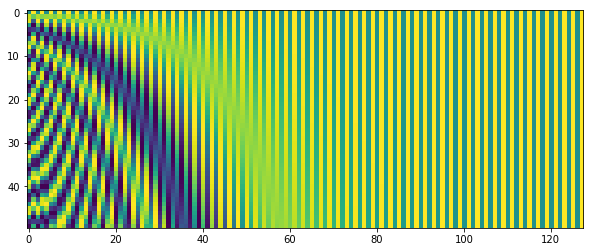

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

positional_enc = PositionalEncoding(128).to(device)
data = torch.zeros(1, 50, 128).to(device)
data_pos_enc = positional_enc.forward(data)

enc_np = data_pos_enc.squeeze(dim=0).to('cpu').numpy()
fig, ax = plt.subplots(figsize=(12, 4))
ax.imshow(enc_np)
plt.show()

## The Transformer model

The biggest addition to the Transformer module is the translate() function. The translate function reads the source sentence, encodes it with one encoder forward run and then using the **Value** and **Key** matrices from encoder it runs the decoder as many times as needed, generating one additional word per run, until the < end-of-sentence > token is generated or max sentence length is reached.

In [12]:

class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_att_heads, input_dict_size, output_dict_size):
        super().__init__()

        self.max_sent_len = 50

        self.input_emb = nn.Embedding(input_dict_size, d_model)
        self.outp_emb = nn.Embedding(output_dict_size, d_model)

        self.positional_encoder = PositionalEncoding(d_model)
        self.encoder = Encoder(num_layers, d_model, num_att_heads)
        self.decoder = Decoder(num_layers, d_model, num_att_heads)

        self.outp_logits = nn.Linear(d_model, output_dict_size)
        self.softmax = nn.Softmax(dim=2)

    def translate(self, src, tgt_start_code, tgt_eos_code, src_padding_mask, src_subsq_mask):

        # TODO: Beam search

        enc_x = self.input_emb.forward(src.squeeze(dim=2))
        enc_x = self.positional_encoder.forward(enc_x)
        enc_keys, enc_values = self.encoder.forward(enc_x, src_padding_mask, src_subsq_mask)

        snt = torch.ones((1,1,1)) * tgt_start_code
        snt = snt.long()
        snt = snt.to(device)

        translation_idxes = []

        for idx in range(self.max_sent_len):

            dec_x = self.outp_emb.forward(snt.squeeze(dim=2))
            dec_x = self.positional_encoder.forward(dec_x)
            dec_x = self.decoder.forward(
                dec_x,
                src_padding_mask = src_padding_mask,
                tgt_padding_mask = torch.zeros_like(snt).float().to(device),
                tgt_subsq_mask = get_square_subsequent_mask(snt.size()[1]),
                mem_keys = enc_keys,
                mem_values = enc_values
            )
            dec_x = self.outp_logits.forward(dec_x)
            dec_x = self.softmax(dec_x)
            next_word_softmax = dec_x[0,idx,:].to('cpu').detach()
            next_word_idx = torch.argmax(next_word_softmax)
            snt = torch.cat([snt, torch.ones((1,1,1)).long().to(device) * next_word_idx], dim=1)

            translation_idxes.append(next_word_idx)

            if next_word_idx == tgt_eos_code:
                break

        return translation_idxes


    def forward(self, src, tgt, src_padding_mask, src_subsq_mask, tgt_padding_mask, tgt_subsq_mask):

        enc_x = self.input_emb.forward(src.squeeze(dim=2))
        enc_x = self.positional_encoder.forward(enc_x)
        enc_keys, enc_values = self.encoder.forward(enc_x, src_padding_mask, src_subsq_mask)

        dec_x = self.outp_emb.forward(tgt.squeeze(dim=2))
        dec_x = self.positional_encoder.forward(dec_x)
        dec_x = self.decoder.forward(dec_x, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, enc_keys, enc_values)
        dec_x = self.outp_logits.forward(dec_x)
        dec_x = self.softmax(dec_x)

        return dec_x

### Some helper functions

In [13]:
def get_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len).to(device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def get_padding_mask(input, val1 = float('-inf'), val2 = float(0.0)):
    mask = torch.ones(input.size()).to(device)
    mask = mask.float().masked_fill(input == 0, val1).masked_fill(input > 0, val2)
    return mask


def get_one_hot(x, out_dim, mask):

    tens = x.view(-1)
    tens_one_hot = torch.zeros(list(tens.size()) + [out_dim]).to(device)
    for i in range(len(tens)):
        tens_one_hot[i,tens[i]] = 1

    tens_one_hot = tens_one_hot.view(list(x.size()) + [out_dim])
    tens_one_hot = tens_one_hot * mask
    return tens_one_hot.to(device)

In [14]:
#Prepare the sentence for model translate function
def translate_sentences(src_sentences, tgt_sentences, max_sent_num = 15):

    transformer_model.eval()

    with torch.no_grad():

        for snt_idx in range(len(src_sentences)):

            if snt_idx > max_sent_num:
                break

            src = src_sentences[snt_idx:snt_idx+1]

            padded_src = pad_sequence(src, padding_value=0, batch_first=True).to(device)
            src_padding_mask = get_padding_mask(padded_src)
            src_subsq_mask = get_square_subsequent_mask(padded_src.size()[1])

            snt_translation = transformer_model.translate(
                src = padded_src,
                tgt_start_code = dataset.get_eng_start_code(),
                tgt_eos_code = dataset.get_eng_eos_code(),
                src_padding_mask = src_padding_mask,
                src_subsq_mask = src_subsq_mask
            )

            src_sent = ''
            for word_idx in src_sentences[snt_idx]:
                src_sent = f"{src_sent} {dataset.fra_token_to_text[word_idx]}"

            tgt_sent = ''
            for word_idx in tgt_sentences[snt_idx]:
                tgt_sent = f"{tgt_sent} {dataset.eng_token_to_text[word_idx]}"

            translated_sent = ''
            for word_idx in snt_translation:
                translated_sent = f"{translated_sent} {dataset.eng_token_to_text[word_idx]}"

            print(f"Source sentence is: {src_sent}")
            print(f"Target sentence is: {tgt_sent}")
            print(f"Model translation is: {translated_sent}")

    transformer_model.train()

### Hyperparams, model definition and dataset

In [15]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
EPOCHS = 30
STORE_MODELS = True
models_path = 'models'

if not os.path.exists(models_path):
    os.mkdir(models_path)

dataset = FraEngDataset()
sentences_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, collate_fn=fra_eng_dataset_collate)

in_dict_size = dataset.get_fra_dict_size()
out_dict_size = dataset.get_eng_dict_size()

transformer_model = Transformer(
    num_layers=6,
    d_model=512,
    num_att_heads=8,
    input_dict_size=in_dict_size,
    output_dict_size=out_dict_size
).to(device)

optimizer = torch.optim.Adam(transformer_model.parameters(), lr = 1e-4)


170190


# Training and sentence translation
To follow the porgress of the model closer I will run translation of few sentences after every 500 processed batches. 

In [ ]:
batch_count = 0

for epoch in range(EPOCHS):

    train_loss_sum = 0.0
    total_word_count = 0.0

    for sentences in sentences_loader:

        src_sentences = sentences['fra_sentences']
        tgt_sentences = sentences['eng_sentences']

        batch_count+=1
        if batch_count % 500 == 0:
            print("#" * 10 + f"  Few translations after {batch_count} batches  " + "#" * 60)
            translate_sentences(src_sentences,tgt_sentences)
            continue

        tgt_sentences_out = []

        for idx in range(len(tgt_sentences)):
            tgt_sentences_out.append(tgt_sentences[idx][1:])
            tgt_sentences[idx] = tgt_sentences[idx][:-1]

        # Create tensors from token lists
        padded_src = pad_sequence(src_sentences, padding_value=0, batch_first=True).to(device)
        padded_tgt = pad_sequence(tgt_sentences, padding_value=0, batch_first=True).to(device)
        padded_tgt_out = pad_sequence(tgt_sentences_out, padding_value=0, batch_first=True).to(device)

        src_padding_mask = get_padding_mask(padded_src)
        src_subsq_mask = get_square_subsequent_mask(padded_src.size()[1])

        tgt_padding_mask = get_padding_mask(padded_tgt)
        tgt_subsq_mask = get_square_subsequent_mask(padded_tgt.size()[1])


        pred = transformer_model.forward(
            src=padded_src,
            tgt=padded_tgt,
            src_padding_mask=src_padding_mask,
            src_subsq_mask=src_subsq_mask,
            tgt_padding_mask=tgt_padding_mask,
            tgt_subsq_mask=tgt_subsq_mask
        )

        # Mask to zero one hot vectors corresponding to padded elements
        one_hot_mask = get_padding_mask(padded_tgt_out, val1=float(0.0), val2=float(1.0))
        y_one_hot = get_one_hot(padded_tgt_out.squeeze(dim=2), out_dict_size, mask=one_hot_mask)

        loss = - torch.sum(torch.log(pred) * y_one_hot)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss_sum += loss.detach().to('cpu').data
        total_word_count += torch.sum(y_one_hot).to('cpu').data

    print(f"Epoch {epoch} " + '=' * 60)
    print(f"Total loss per word: {train_loss_sum / total_word_count}")
    print(f"Some translated sentences:")
    

    if STORE_MODELS == True:
        model_path = os.path.join(models_path, f'Epoch_{epoch}_model.pt')
        torch.save(transformer_model, model_path)

print("Traing done! Generating some more sentences.")


##########  Few translations after 500 batches  ############################################################
Source sentence is:  Êtes-vous sûr de ne pas vouloir attendre jusqu ' à demain ? <EOS>
Target sentence is:  <START> Are you sure you do n't want to wait till tomorrow ? <EOS>
Model translation is:  Are you sure you do n't want to be here ? <EOS>
Source sentence is:  Je ne sais pas en ce qui te concerne mais , moi , je crève de faim . <EOS>
Target sentence is:  <START> I do n't know about you , but I 'm starved . <EOS>
Model translation is:  I do n't know who you , but I 'm going to be going to me . <EOS>
Source sentence is:  Je ne sais pas de combien de minutes nous disposons . <EOS>
Target sentence is:  <START> I do n't know how many minutes we 've got . <EOS>
Model translation is:  I do n't know how to know how to know us . <EOS>
Source sentence is:  Je dois vraiment rentrer chez moi et dormir . <EOS>
Target sentence is:  <START> I really need to go home and catch some zees . 

Source sentence is:  S'il ne pleut pas bientôt , notre jardin va se dessécher . <EOS>
Target sentence is:  <START> If it does n't rain soon , our garden is going to dry up . <EOS>
Model translation is:  If it does n't have soon , our garden will be going to go . <EOS>
Source sentence is:  Le français est une des langues que j'ai toujours voulu apprendre . <EOS>
Target sentence is:  <START> French is one of the languages I 've always wanted to learn . <EOS>
Model translation is:  French is a languages that I wanted to learn . <EOS>
Source sentence is:  Je suis désolée . Je ferai n'importe quoi pour réparer cela . <EOS>
Target sentence is:  <START> I 'm sorry . I 'll do anything to make this right . <EOS>
Model translation is:  I 'm sorry . I 'll do anything to do that . <EOS>
Source sentence is:  Elle est occupée à l'heure qu'il est , donc elle ne peut pas vous parler . <EOS>
Target sentence is:  <START> She 's busy now , so she ca n't talk with you . <EOS>
Model translation is:  She 's

Source sentence is:  Elle a trié le linge avant de le mettre dans la machine à laver . <EOS>
Target sentence is:  <START> She sorted the washing before putting it in the washing machine . <EOS>
Model translation is:  She forced the town before the machine in the machine . <EOS>
Source sentence is:  Je ne peux m'empêcher d'avoir l'impression d'avoir oublié quelque chose . <EOS>
Target sentence is:  <START> I ca n't help but feel like I 've forgotten something . <EOS>
Model translation is:  I ca n't help him feel like I forgot . <EOS>
Source sentence is:  Je chantais tous les jours quand j'étais enfant . <EOS>
Target sentence is:  <START> I used to sing every day when I was a child . <EOS>
Model translation is:  I 'll get all day when I was a kid . <EOS>
Source sentence is:  Elle essaya de le réconforter mais il continua à pleurer . <EOS>
Target sentence is:  <START> She tried to comfort him , but he kept crying . <EOS>
Model translation is:  She tried to take him , but he was crying to 

Source sentence is:  Il est dur d'écraser une mouche à mains nues . <EOS>
Target sentence is:  <START> It 's hard to swat a fly with your bare hand . <EOS>
Model translation is:  It 's hard to make a new hands . <EOS>
Source sentence is:  Dans ma ville , il n ' y a pas d'école pour apprendre l'espéranto . <EOS>
Target sentence is:  <START> In my city , there is no school for learning Esperanto . <EOS>
Model translation is:  In my town , there is no use to learn . <EOS>
Source sentence is:  Que devrions-nous faire s'il s'avère qu'il vient tard ? <EOS>
Target sentence is:  <START> What should we do if he happens to come late ? <EOS>
Model translation is:  What should we do if he comes late ? <EOS>
Source sentence is:  Ce n'est pas facile d'être compris par tout le monde . <EOS>
Target sentence is:  <START> It is not easy to be understood by everybody . <EOS>
Model translation is:  It 's not easy to be understand everyone . <EOS>
Source sentence is:  Qui de vous deux viendra avec moi ? <E

Source sentence is:  Je ne veux plus vivre avec toi . <EOS>
Target sentence is:  <START> I do n't want to live with you anymore . <EOS>
Model translation is:  I do n't want to live with you anymore . <EOS>
Source sentence is:  Ils se sont réunis dans une ferme dans l'État de New-York . <EOS>
Target sentence is:  <START> They gathered at a farm in New York State . <EOS>
Model translation is:  They started in a farm farm in New York . <EOS>
Source sentence is:  Elle déduisit de son silence qu'il était en colère . <EOS>
Target sentence is:  <START> She inferred from his silence that he was angry . <EOS>
Model translation is:  She is angry with her silence he was angry . <EOS>
Source sentence is:  J'ai trouvé aisé de répondre à la question . <EOS>
Target sentence is:  <START> I found it easy to answer the question . <EOS>
Model translation is:  I found it easy to answer the question . <EOS>
Source sentence is:  On va faire ce qu'on peut . <EOS>
Target sentence is:  <START> We 're going to 

Source sentence is:  Pouvons-nous avoir un moment seuls , s'ils vous plaît ? <EOS>
Target sentence is:  <START> Can we have a moment alone , please ? <EOS>
Model translation is:  Can we have a moment , please ? <EOS>
Source sentence is:  Y aura-t-il la moindre nourriture à la fête ? <EOS>
Target sentence is:  <START> Will there be any food at the party ? <EOS>
Model translation is:  Do you have any food at the party ? <EOS>
Source sentence is:  Je veux que vous restiez un peu plus longtemps . <EOS>
Target sentence is:  <START> I want you to stay a little longer . <EOS>
Model translation is:  I want you to stay a little longer . <EOS>
Source sentence is:  J'ignore comment vous contacter . <EOS>
Target sentence is:  <START> I do n't know how to contact you . <EOS>
Model translation is:  I do n't know how to contact you . <EOS>
Source sentence is:  Bah ! Ça fait une paille . <EOS>
Target sentence is:  <START> Wow ! It 's been a long time . <EOS>
Model translation is:  She 's done ! It 's 

Source sentence is:  Je veux vous aider à sortir de ce pétrin . <EOS>
Target sentence is:  <START> I want to help you get out of this mess . <EOS>
Model translation is:  I want to help you go out . <EOS>
Source sentence is:  Fais-moi savoir s'il y a quoi que ce soit que je puisse faire . <EOS>
Target sentence is:  <START> Let me know if there is anything I can do . <EOS>
Model translation is:  Let me know if there 's anything I can do . <EOS>
Source sentence is:  Tout ce que tu lis sur Internet n'est pas vrai . <EOS>
Target sentence is:  <START> Not everything that you read on the Internet is true . <EOS>
Model translation is:  All you read is true . <EOS>
Source sentence is:  Voulez-vous savoir pourquoi j'ai menti à Tom ? <EOS>
Target sentence is:  <START> Do you want to know why I lied to Tom ? <EOS>
Model translation is:  Do you want to know why I lied to Tom ? <EOS>
Source sentence is:  Elle avertit les enfants de ne pas jouer dans la rue . <EOS>
Target sentence is:  <START> She wa

Source sentence is:  La cause de l'accident est encore obscure . <EOS>
Target sentence is:  <START> The cause of the accident is still obscure . <EOS>
Model translation is:  The cause of the accident is still a lot of fun . <EOS>
Source sentence is:  Certaines personnes sont fascinées par les nouvelles choses étincelantes . <EOS>
Target sentence is:  <START> Some people are fascinated by shiny new things . <EOS>
Model translation is:  Some people are covered by the new things . <EOS>
Source sentence is:  Vous devriez être plus prudent , la prochaine fois . <EOS>
Target sentence is:  <START> You should be more careful the next time . <EOS>
Model translation is:  You should be more careful the next time . <EOS>
Source sentence is:  Elle a donné d'innombrables pièces au musée . <EOS>
Target sentence is:  <START> She donated countless pieces to the museum . <EOS>
Model translation is:  She gave him a pieces pieces to the museum . <EOS>
Epoch 2 ==============================================

Source sentence is:  Je ne veux vraiment pas décevoir Tom . <EOS>
Target sentence is:  <START> I really do n't want to disappoint Tom . <EOS>
Model translation is:  I really do n't want to disappoint Tom . <EOS>
##########  Few translations after 9000 batches  ############################################################
Source sentence is:  Pensez-vous que vos parents ont passé suffisamment de temps avec vous lorsque vous étiez adolescents ? <EOS>
Target sentence is:  <START> Do you think your parents spent enough time with you when you were in your teens ? <EOS>
Model translation is:  Do you think your parents spent enough time with you when you were in your teens ? <EOS>
Source sentence is:  Soyez calmes . Si vous n'êtes pas calmes , on vous jettera dehors . <EOS>
Target sentence is:  <START> Be quiet . If you are n't quiet , you 'll be thrown out . <EOS>
Model translation is:  Be quiet . If you 're not quiet , you 're being thrown out . <EOS>
Source sentence is:  Autant que je vivra

##########  Few translations after 10000 batches  ############################################################
Source sentence is:  Dites-moi la raison pour laquelle vous voulez vivre à la campagne . <EOS>
Target sentence is:  <START> Tell me the reason why you want to live in the countryside . <EOS>
Model translation is:  Tell me the reason you want to live in the country . <EOS>
Source sentence is:  Nous vivons tous à moins de cinq minutes de marche les uns des autres . <EOS>
Target sentence is:  <START> We all live within a five minutes ' walk from each other . <EOS>
Model translation is:  We live less than five minutes ' walk each other . <EOS>
Source sentence is:  « Que feras-tu ? » demanda son amie . <EOS>
Target sentence is:  <START> `` What will you have to do ? '' asked her friend . <EOS>
Model translation is:  `` What will you do ? '' asked his friend . <EOS>
Source sentence is:  Vous travaillez trop ces derniers temps . N'êtes-vous donc pas fatigués ? <EOS>
Target sentence i

##########  Few translations after 11000 batches  ############################################################
Source sentence is:  Si ce n'avait été par votre stupidité , nous n'aurions jamais eu tous ces ennuis . <EOS>
Target sentence is:  <START> If it had not been for your foolishness , we would never have been in that trouble . <EOS>
Model translation is:  If it had n't been for your foolishness , we would never have all this trouble . <EOS>
Source sentence is:  Passer du temps avec ta bien-aimée devrait être en tête de ta liste de priorités . <EOS>
Target sentence is:  <START> Spending time with your significant other should be high on your priority list . <EOS>
Model translation is:  Spending time with your significant other should be high on your priority list . <EOS>
Source sentence is:  Je n'arrive pas à croire que tu étais l'enfant le plus intelligent de ta classe . <EOS>
Target sentence is:  <START> I ca n't believe that you were the smartest kid in your class . <EOS>
Model

Source sentence is:  Dépêchons-nous ! Nous ne voulons pas être en retard . <EOS>
Target sentence is:  <START> Let 's hurry . We do n't want to be late . <EOS>
Model translation is:  Let 's hurry . We do n't want to be late . <EOS>
Source sentence is:  Vous devriez être en mesure de marcher dans quelques jours . <EOS>
Target sentence is:  <START> You should be able to walk in a few days . <EOS>
Model translation is:  You should be able to walk in a few days . <EOS>
Source sentence is:  Tu es soit avec soit contre moi . <EOS>
Target sentence is:  <START> You 're either with me or you 're against me . <EOS>
Model translation is:  You 're either with me . <EOS>
Source sentence is:  `` Si , j ' y étais '' , répondit cet étudiant . <EOS>
Target sentence is:  <START> `` Yes , I was , '' said the student . <EOS>
Model translation is:  `` If I were there , I would have been there . <EOS>
Source sentence is:  L'eau gèle à zéro degré , n'est-ce pas ? <EOS>
Target sentence is:  <START> Water freez

Source sentence is:  Tu ne devrais pas étudier toute la journée . Tu devrais sortir et t'amuser . <EOS>
Target sentence is:  <START> You should n't study all day long . You should go out and have some fun . <EOS>
Model translation is:  You should n't study all day . You should go out and have a child . <EOS>
Source sentence is:  Je ne sais pas s'il l'aurait fait pour moi . <EOS>
Target sentence is:  <START> I do n't know if he would have done it for me . <EOS>
Model translation is:  I do n't know if he will have done it for me . <EOS>
Source sentence is:  Je n'avais pas compris un mot de ce que John venait de dire . <EOS>
Target sentence is:  <START> I did n't hear a word of what Tom just said . <EOS>
Model translation is:  I did n't understand a word of what John was trying to say . <EOS>
Source sentence is:  Il apporta de la nourriture à son invitée et lui procura un abri . <EOS>
Target sentence is:  <START> He brought food to his guest and provided him shelter . <EOS>
Model translat

Source sentence is:  Je ne me sentais pas bien , mais je suis allé travailler . <EOS>
Target sentence is:  <START> I did n't feel well , but I went to work . <EOS>
Model translation is:  I did n't felt well , but I went to work . <EOS>
Source sentence is:  Je prévois de décrocher un emploi dès que je peux . <EOS>
Target sentence is:  <START> I plan to get a job as soon as I can . <EOS>
Model translation is:  I plan to get a job as soon as I can . <EOS>
Source sentence is:  Elle parle hébreu avec sa mère et polonais avec son père . <EOS>
Target sentence is:  <START> She speaks Hebrew with her mother and Polish with her father . <EOS>
Model translation is:  She speaks growing with her mother and mother 's with her father . <EOS>
Source sentence is:  Je saisis la main de ma petite sœur et me mit à courir . <EOS>
Target sentence is:  <START> I grabbed my little sister 's hand and started running . <EOS>
Model translation is:  I grabbed my little sister 's hand and started running . <EOS>
S